In [2]:
# import MetaTrader5 as mt5
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, argrelextrema
import numpy as np
from datetime import datetime, timedelta
from strategy import Strategy

# Define the forex pair and timeframe
symbol = "Volatility 10 Index"
# timeframe = mt5.TIMEFRAME_M15

# Define the start and end times for the data
start_time = pd.to_datetime("2022-01-01 00:00:00")  # Replace with a valid start date
end_time = pd.to_datetime("2024-05-04 23:59:59")  # Replace with a valid end date


def get_historical_data(symbol, timeframe, start_time, end_time):
    """Retrieves historical data from the MT5 terminal and saves it to a CSV file.

    Args:
        symbol (str): The forex pair to retrieve data for.
        timeframe (int): The timeframe to retrieve data in. Must be one of the
            TIMEFRAME_* constants from the MetaTrader5 module.
        start_time (datetime): The starting date and time for the data retrieval.
        end_time (datetime): The ending date and time for the data retrieval.
    """

    # Initialize MT5 connection
    if not mt5.initialize():
        print("initialize() failed, error code =", mt5.last_error())
        quit()

    # Retrieve historical data
    rates = mt5.copy_rates_range(symbol, timeframe, start_time, end_time)

    # Check if data was retrieved successfully
    if rates is None:
        print("No data retrieved, error code =", mt5.last_error())
        mt5.shutdown()  # Shutdown the connection
        quit()

    # Convert the data to a pandas DataFrame
    df = pd.DataFrame(rates)
    df["time"] = pd.to_datetime(df["time"], unit="s")  # Convert timestamp to datetime

    # Save the data to a CSV file
    df.to_csv("forex_data_ex.csv", index=False)

    # Close the connection to MetaTrader5
    mt5.shutdown()


# get_historical_data(symbol, timeframe, start_time, end_time)

In [12]:
"""
Plot the {symbol} 1 hour candlestick chart using mplfinance.

This script loads the data from a CSV file, converts the 'time'
column to a datetime and sets it as the index. It then converts
the DataFrame to the format expected by mplfinance and plots the
candlestick chart using the 'charles' style.
"""

def reduceDataSize(df) -> pd.DataFrame:
    # set the dates to filter
    start_date = pd.to_datetime("2024-01-01 00:00:00")
    end_date = pd.to_datetime("2024-01-03 23:59:59") 

    df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]

    return df


def prepData(visualize=False):
    # Load the data from the CSV file
    df = pd.read_csv("forex_data_ex.csv")

    # Convert the 'time' column to datetime if it's not already
    df["time"] = pd.to_datetime(df["time"])

    # used to filter the data to a small workable portion is it is too large

    # df = reduceDataSize(df)  # uncomment this to activate

    # Set the 'time' column as the index
    df.set_index("time", inplace=True)

    # Convert the DataFrame to the format expected by mplfinance
    ohlcv_data = df[["open", "high", "low", "close", "tick_volume"]]

    # Rename the columns to the format expected by mplfinance
    ohlcv_data.columns = ["Open", "High", "Low", "Close", "Volume"]

    if visualize:
        # Plot the candlestick chart
        mpf.plot(
            ohlcv_data,
            type="candle",
            style="charles",
            title=f"{symbol} 1 Hour",
            volume=True,
        )
        return ohlcv_data
    else:
        return ohlcv_data


df = prepData(visualize=False)

In [13]:
# Assuming df is your DataFrame and 'Close' is the column with the closing prices
def cleanData(visualize=False) -> None:
    window_length = 15
    polyorder = 8

    # Apply the Savitzky-Golay filter to the 'Close' prices
    smoothed_close = savgol_filter(df["Close"], window_length, polyorder)

    df["smoothed_close"] = smoothed_close

    if visualize:
        # Plot original data
        plt.plot(df.index, df["Close"], label="Close Price")

        # # Plot smoothed data
        plt.plot(df.index, df["smoothed_close"], label="Smoothed Close Price")


cleanData()

/home/alphacode_x/Documents/pythonProjects/Forex/EchealNet_SMC_BOT/env/lib64/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


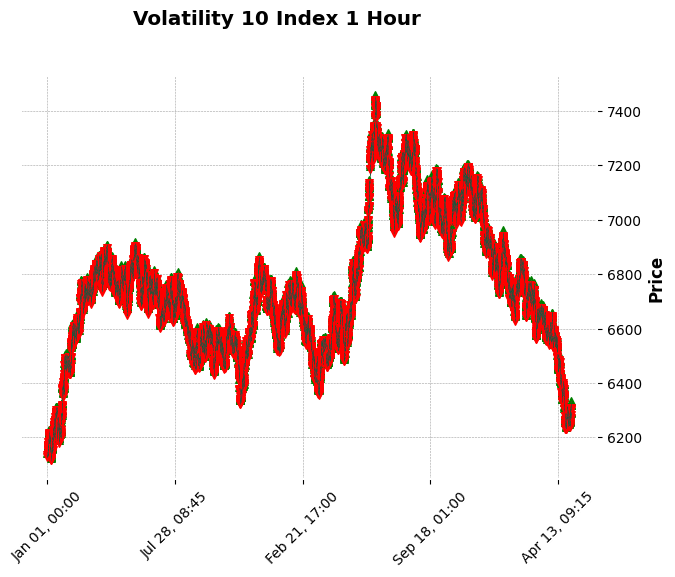

In [14]:
def detectPivotPoints(visualize=False):
    # Detect highs and lows
    highs = argrelextrema(df["smoothed_close"].to_numpy(), np.greater, mode="wrap", order=3)
    lows = argrelextrema(df["smoothed_close"].to_numpy(), np.less, mode="wrap", order=3)

    df["Is_High"] = df["High"].iloc[highs[0]]
    df["Is_Low"] = df["Low"].iloc[lows[0]]

    df.fillna(0)

    if visualize:
        apd = [
            mpf.make_addplot(
                df["Is_High"], scatter=True, markersize=30, marker="^", color="g"
            ),
            mpf.make_addplot(
                df["Is_Low"], scatter=True, markersize=30, marker="v", color="r"
            ),
        ]

        mpf.plot(
            df, type="candle", addplot=apd, style="charles", title=f"{symbol} 1 Hour"
        )


detectPivotPoints(visualize=True)

In [5]:
strategy = Strategy(df)

plot_df = strategy.BreakerBlock(RR=5)
# plot_df = strategy.AMSstrategy(RR=5)

print(plot_df)

              Occurence     Entry  Stop_Loss  Take_Profit  \
0   2022-01-02 10:30:00  6179.284   6189.277     6129.319   
1   2022-01-03 20:30:00  6221.569   6237.091     6143.959   
2   2022-01-06 03:15:00  6163.304   6184.843     6055.609   
3   2022-01-09 14:15:00  6213.299   6223.883     6160.379   
4   2022-01-23 20:30:00  6280.416   6298.022     6192.386   
..                  ...       ...        ...          ...   
209 2024-04-19 05:45:00  6415.674   6433.550     6326.294   
210 2024-04-22 16:15:00  6399.391   6413.242     6330.136   
211 2024-04-25 08:00:00  6270.672   6322.952     6009.272   
212 2024-04-27 19:30:00  6277.597   6299.320     6168.982   
213 2024-05-03 08:00:00  6260.044   6275.574     6182.394   

     Risk_to_Reward_Ratio  
0                     5.0  
1                     5.0  
2                     5.0  
3                     5.0  
4                     5.0  
..                    ...  
209                   5.0  
210                   5.0  
211            

In [6]:
def plot(trade):

    start_time = trade.Occurence - timedelta(hours=30)
    specific_datetime = trade.Occurence

    end_time = specific_datetime + timedelta(hours=100)

    # Slice the DataFrame using the datetime objects
    dfpl = df.loc[start_time:end_time]

    # Print the length of the sliced data to ensure it has the same length as the pivot points data
    print(len(dfpl))

    # Convert the specific datetime to a datetime object
    apd = [
        mpf.make_addplot(
            dfpl["Is_High"], scatter=True, markersize=30, marker="^", color="b"
        ),
        mpf.make_addplot(
            dfpl["Is_Low"], scatter=True, markersize=30, marker="v", color="r"
        ),
    ]
    # Plot the candlestick chart with the pivot points and moving averages
    mpf.plot(
        dfpl,
        type="candle",
        style="nightclouds",
        title=f"{symbol}",
        warn_too_much_data=9999999999,
        addplot=apd,  # Slice apd here
        vlines=[specific_datetime],
        hlines=[trade.Stop_Loss, trade.Take_Profit, trade.Entry],
    )


for trade in plot_df.itertuples():
    # plot(trade)  # Uncomment this to plot charts
    1 == 1

In [7]:
# Define global variables
balance = 100
risk_type = "money"  # percentage or money
risk_amount = 5
highest_count = 0
RR=5


# Define the backtest function
def backtest(df, plot_df, RR, balance, risk_amount):
    results = []
    wins = 0
    losses = 0
    neither = 0
    

    # Iterate over each trade occurrence in plot_df
    for trade in plot_df.itertuples():
        entry_price = trade.Entry
        stop_loss = trade.Stop_Loss
        take_profit = trade.Take_Profit
        occurrence_time = trade.Occurence

        # Determine the outcome of the trade based on subsequent price movement
        price_reached_stop_loss = False
        price_reached_take_profit = False

        # Find the index corresponding to the occurrence time
        occurrence_index = df.index.get_loc(occurrence_time)

        # Check if the entry price is reached or exceeded
        entry_reached = False
        if risk_type == "percentage":
            Risk = risk_amount / 100 * balance
        else:
            Risk = risk_amount

        # Iterate over subsequent rows to check for entry price or stop loss/take profit
        for i in range(occurrence_index + 1, len(df)):
            high_price = df.iloc[i]["High"]

            # Check if price reaches or exceeds the entry price
            if high_price >= entry_price:
                entry_reached = True  # Set flag to indicate entry price is reached

            # Once entry price is reached or exceeded, check for stop loss/take profit
            if entry_reached:
                # Check if price reaches stop loss
                if high_price >= stop_loss:
                    price_reached_stop_loss = True
                    balance = (balance - Risk)  # Deduct risk amount from balance (stop loss)

                    break

                # Check if price reaches take profit
                if high_price <= take_profit:
                    price_reached_take_profit = True
                    balance = balance + (Risk * RR)  # Add reward amount to balance (take profit)

                    break

        # Determine trade outcome based on price movement
        if price_reached_stop_loss:
            result = "SL"
            losses += 1
        elif price_reached_take_profit:
            result = "TP"
            wins += 1
        else:
            result = "Neither Hit"
            neither += 1

        # Calculate trade statistics
        trade_result = {
            "Occurrence": occurrence_time,
            "Entry": entry_price,
            "Stop_Loss": stop_loss,
            "Take_Profit": take_profit,
            "Result": result,
            "Balance": balance,
        }

        results.append(trade_result)

    # Create a DataFrame from the list of trade results
    backtest_df = pd.DataFrame(results)
    

    return backtest_df, wins, losses, neither


# Assuming df and plot_df are defined elsewhere in your code
# Perform backtest on trades and store results in a DataFrame
# RR should be defined as well
backtest_results_df, wins, losses, neither = backtest(df, plot_df, RR, balance, risk_amount)

print(f"wins {wins}")
print(f"loss {losses}")
print(f"none {neither}")

# Initialize variables to keep track of the current count of consecutive stop loss hits
# and the highest count found so far
current_count = 0
highest_count = 0

# Iterate through the filtered DataFrame to count consecutive stop loss hits
for i in range(len(backtest_results_df)):
    if (
        backtest_results_df.iloc[i]["Result"]
        == backtest_results_df.iloc[i - 1]["Result"]
        == "SL"
    ):
        # If the current row is the first row or the occurrence time is one day after the previous row
        current_count += 1
        if current_count > highest_count:
            # If the current count is higher than the highest count, update the highest count
            highest_count = current_count

    else:
        # If the occurrence time is not consecutive, reset the current count
        current_count = 1

# Print the highest number of consecutive stop loss hits
print(f"Consecutive SL: {highest_count}")
# Display the backtest results DataFrame
print(backtest_results_df[["Balance"]])

wins 32
loss 175
none 7
Consecutive SL: 19
     Balance
0         95
1         90
2         85
3        110
4        105
..       ...
209       40
210       40
211       35
212       30
213       25

[214 rows x 1 columns]


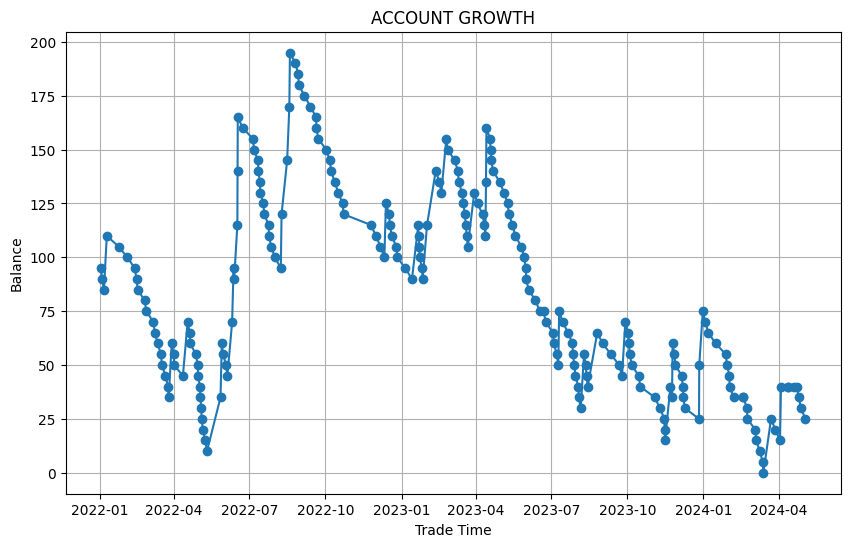

In [8]:
import matplotlib.pyplot as plt


def plot_balance_graph(backtest_results_df):
    # Ensure the DataFrame has the necessary columns
    assert (
        "Balance" in backtest_results_df.columns
    ), "The DataFrame must have a 'Balance' column."
    assert (
        "Occurrence" in backtest_results_df.columns
    ), "The DataFrame must have an 'Occurrence' column."

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(
        backtest_results_df["Occurrence"], backtest_results_df["Balance"], marker="o"
    )
    plt.title("ACCOUNT GROWTH")
    plt.xlabel("Trade Time")
    plt.ylabel("Balance")
    plt.grid(True)
    plt.show()


# Example usage:
# Assuming backtest_results_df is defined and contains the necessary columns
plot_balance_graph(backtest_results_df)